# Growth Effect Heat Maps

This code makes each panel of the heatmap comparing growth effects in Figure 3 of Mathis et al. It takes average growth effect data from previous analyses and outputs a clustered heat map of growth effects different guide design groups (SG1 Compounding mismatches, SG1 Single mismatches, etc.). Clustering is based on SG1 Compounding mismatch guides. The notebook can analyze glucose or glycerol data.

26 June 2020
Written by Andrew D. Mathis
Edited by Ryan Otto

## Import useful libraries

In [1]:
import pandas as pd # Data organization
import numpy as np # Data organization
from scipy.cluster.hierarchy import dendrogram, linkage # Clustering function
import matplotlib.pyplot as plt # Plotting function
from matplotlib.ticker import FixedLocator # Heatmap tick locations
import warnings # Used to filter a RuntimeWarning when dealing with missing data
# Renders figures in notebook
%matplotlib inline

## Establish all paths and variables unique to this analysis.

Default values to recreate figures are provided.

In [2]:
df_path = 'outputs/' # Path for data frames output by HiSeq Analysis code
figure_path = 'Figures/' # General path for saving figures

# Choose which media to analyze
media = 'Glu' # 'Glu' or 'Gly' in our data

# Date for labeling output
date = '20200923'

# Central Functions for Analysis

These functions are used to allow for genes to be clustered based on the growth effects of their SG1 Compounding guides. The clustering function used doesn't allow nans or missing data, so sudo counts must be added in when real data is absent. To preserve sgRNA growth effect behavior as best we can, missing data points are filled in by averaging the nearest (as is most similar sgRNA by number of mismatches) available data. A heat map plotting function is also included for simplicity.

In [3]:
# Sudo counting script to fill emptypoints for sgRNAs without a valid measurement at a given timepoint.
# Input -- df_guides: Data frame containing guides to cluster in downstream analysis
#          drop: List of any gene names appearing in df_guides that should be excluded from clustering
# Output -- df_sudo: Data frame filled with placeholder growth effect data when needed and "drop" genes removed
def sudo_count(df_guides, drop):

    # Remove "drop" genes and initialize df_sudo as a deep copy for editing purposes
    df_drop = df_guides.drop(drop)
    df_sudo = df_drop.copy(deep=True)
    
    for gene in df_drop.index: # For each gene remaining
        initial_growth = df_drop.loc[gene]
        new_growth = []
        for i, col in enumerate(df_drop.columns):
            # Pull out individual growth effect data
            growth_effect = df_drop[col].loc[gene]
            # If a data point is missing, average surrounding points
            if str(growth_effect) == 'nan': 
                bump = 0 # Initialize averaging region
                # Expand the averaging region around a data point until the data point is filled in
                while str(growth_effect) == 'nan':
                    bump += 1
                    UP = i + bump
                    DOWN = i - bump
                    if DOWN < 0: # Don't let indices go negative
                        DOWN = 0
                    with warnings.catch_warnings(): # Will always get RuntimeWarnings if growth_effect is nan
                        warnings.simplefilter('ignore', category=RuntimeWarning)
                        growth_effect = np.nanmean(initial_growth[DOWN:UP+1])
            new_growth.append(growth_effect)
        df_sudo.loc[gene] = new_growth # Overwrite missing data while keeping original counts
        
    return df_sudo

# Heat map plotting function
# Input -- df_guides: Data frame of growth effect data to plot as a heat map
#          cluster: List of gene names from dendrogram clustering
#          title: Title of plot
#          figure_path: Path for saving figures
#          date: Date on output files
def grid_plot(df_guides, cluster, title, figure_path, date):
    # Initialize fig and ax objects
    fig = plt.figure(figsize=(10.65, 2.5))
    ax = plt.gca()
    
    # Make heat map
    heat_map = ax.imshow(df_guides.reindex(cluster).T, cmap='magma', vmin=0, vmax=1.1)
    fig.colorbar(heat_map, shrink=0.3, ticks=[0, 0.5, 1])
    
    Xindex = np.arange(0, len(df_guides.index))
    Yindex = np.arange(0, len(df_guides.T.index))
    ax.set_xticks(Xindex)
    ax.set_yticks(Yindex)
    ax.set_xticklabels(cluster, rotation=-90, fontsize=8)
    ax.xaxis.set_minor_locator(FixedLocator(np.arange(0.5, len(Xindex), 1)))
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(0.5, len(Yindex), 1)))
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.25)
    ax.set_facecolor('darkgrey')
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(figure_path + date + '_' + title + '.pdf', transparent=True)
    plt.show()
    
    return


## Import data

In [4]:
# Growth effects (negC = 1, cell death = 0) of each sgRNA organized by gene
df_growth_effect = pd.read_csv(df_path + '20200923_df_growth_effect_' + media + '.csv', index_col = 0, 
                               parse_dates = True)

# Separate data for partial heat maps
df_sg1B = df_growth_effect.T.iloc[0:15].T
df_sg1W = df_growth_effect.T.iloc[15:29].T
df_sg1D = df_growth_effect.T.iloc[29:34].T
df_sg3B = df_growth_effect.T.iloc[35:50].T
df_sg3W = df_growth_effect.T.iloc[50:-5].T
df_sg3D = df_growth_effect.T.iloc[-5:].T

# Drop genes lacking SG1-family guides for clustering
drop = ['pykF', 'pyrH', 'nadE', 'dnaA']

## Clustering growth effects based on SG1 Compounding guide behavior

First, fills in missing sgRNA growth effect information for all SG1 Compounding guides. Then clusters genes based on growth effect data for SG1 Compounding guides. Note: In our data, four genes (dnaA, nadE, pykF, and pyrH) lack SG1 sgRNAs, and thus are excluded from clustering but are still present in heat maps.

In [5]:
df_sudo = sudo_count(df_sg1B, drop)

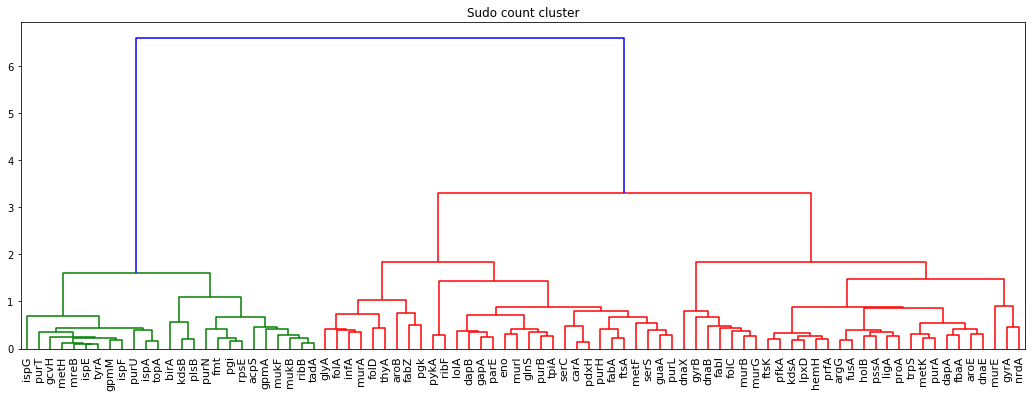

In [6]:
plt.figure(figsize=(18, 6))
Z = linkage(df_sudo, 'ward')
dn = dendrogram(Z, labels=df_sudo.index, leaf_font_size=11)
plt.title('Sudo count cluster')
plt.show()

cluster = drop + dn['ivl']

## Heat maps of guide growth effects

Constructs heat maps of all guide groups using a shared clustering pattern from SG1 Compounding guides

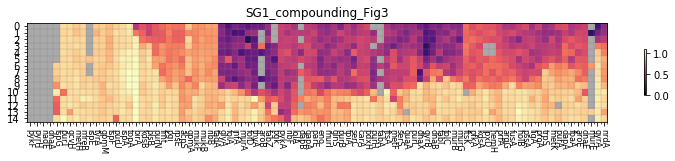

In [7]:
# Figure 3
grid_plot(df_sg1B, cluster, 'SG1_compounding_Fig3', figure_path, date)

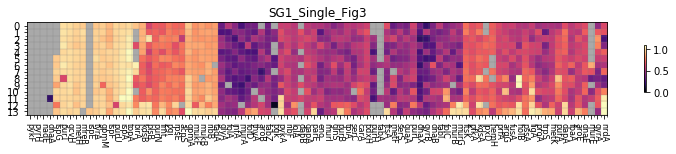

In [8]:
# Figure 3
grid_plot(df_sg1W, cluster, 'SG1_Single_Fig3', figure_path, date)

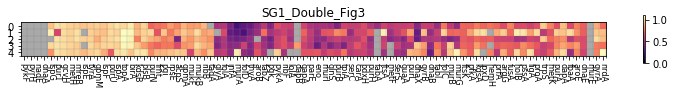

In [9]:
# Figure 3
grid_plot(df_sg1D, cluster, 'SG1_Double_Fig3', figure_path, date)

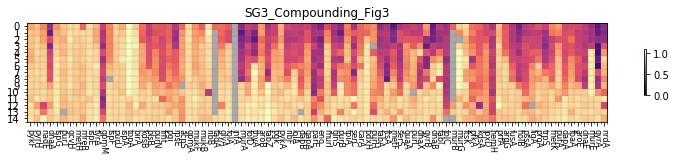

In [10]:
# Figure 3
grid_plot(df_sg3B, cluster, 'SG3_Compounding_Fig3', figure_path, date)

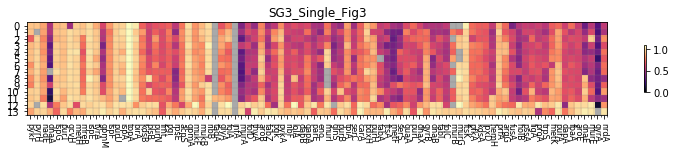

In [11]:
# Figure 3
grid_plot(df_sg3W, cluster, 'SG3_Single_Fig3', figure_path, date)

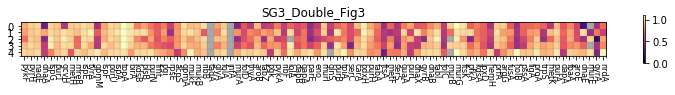

In [12]:
# Figure 3
grid_plot(df_sg3D, cluster, 'SG3_Double_Fig3', figure_path, date)